In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
classes = ['class_0','class_1']
class_1_speakers = ['f1','f7','f8','m3','m6','m8']
filepath = 'daps/cleanraw'

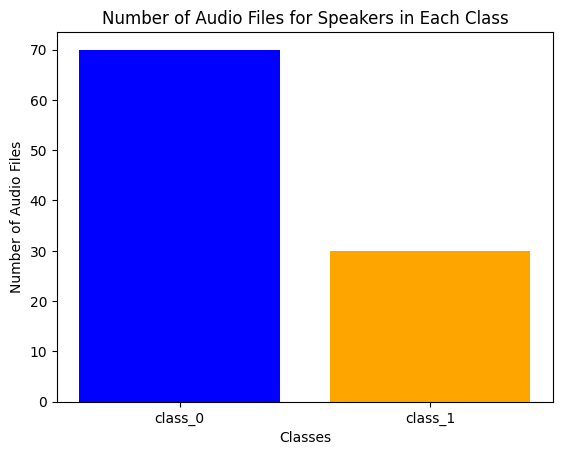

Duration - Mean: 152.9349804988662 Median: 152.40997732426302


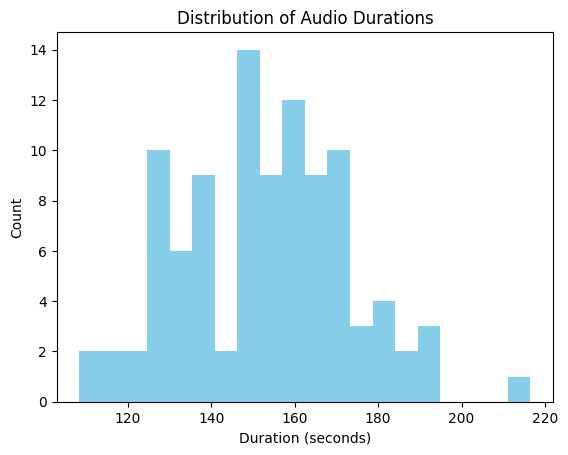

C:\Users\YouRekt\AppData\Local\Temp\ipykernel_37604\44592514.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['duration'].groupby(df['class']).apply(list), labels=classes)
C:\Users\YouRekt\AppData\Local\Temp\ipykernel_37604\44592514.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Class')


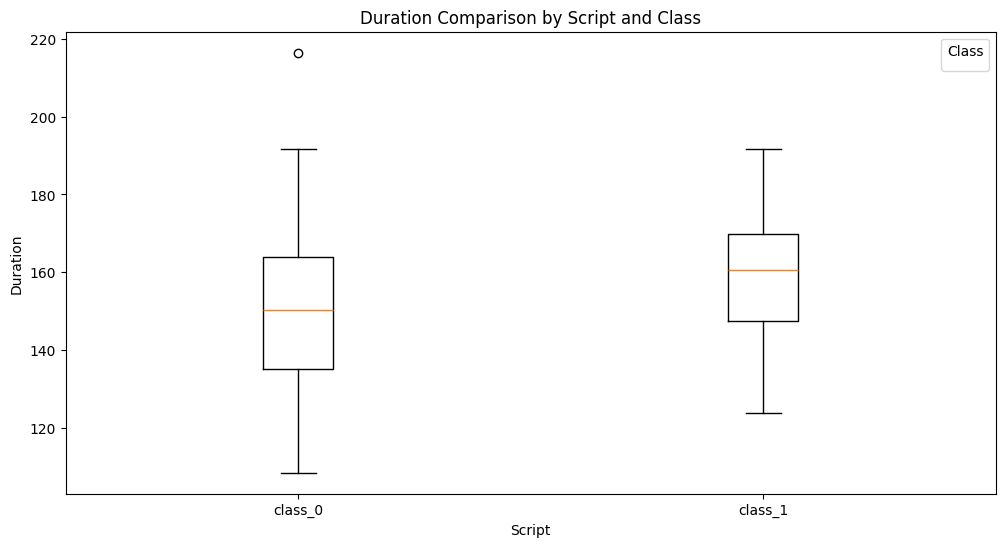

In [29]:
def count_and_plot_speakers():
    data = []
    class_0_spectrograms = []
    class_1_spectrograms = []


    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file),sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        S = librosa.feature.melspectrogram(y=trimmed, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        if file.split('_')[0] in class_1_speakers:
            class_1_spectrograms.append(S_dB)
        else:
            class_0_spectrograms.append(S_dB)        

        data.append({'script': file.split("_")[1], 'speaker': file.split('_')[0], 'class': 'class_1' if file.split('_')[0] in class_1_speakers else 'class_0', 'duration': librosa.get_duration(y=trimmed, sr=sr),'sample rate': sr})

    
    # Plotting
    df = pd.DataFrame(data)

    plt.bar(classes, df['class'].value_counts(), color=['blue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Audio Files')
    plt.title('Number of Audio Files for Speakers in Each Class')
    
    plt.show()
    # print(df.describe())
    # print(df)
    print("Duration - Mean:", np.mean(df['duration']), "Median:", np.median(df['duration']))

    # Plot duration distribution
    plt.hist(df['duration'], bins=20, color='skyblue')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.title('Distribution of Audio Durations')
    plt.show()

    min_length = min(min([len(s) for s in class_0_spectrograms]),min([len(s) for s in class_1_spectrograms]))

    class_0_spectrograms = [s[:min_length] for s in class_0_spectrograms]
    class_1_spectrograms = [s[:min_length] for s in class_1_spectrograms]

    # mean_class_0 = np.mean(class_0_spectrograms, axis=0)
    # mean_class_1 = np.mean(class_1_spectrograms, axis=0)

    # plt.figure(figsize=(10, 5))
    # librosa.display.specshow(mean_class_0, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Average Mel-Spectrogram for Class 0')
    # plt.show()

    # plt.figure(figsize=(10, 5))
    # librosa.display.specshow(mean_class_1, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Average Mel-Spectrogram for Class 1')
    # plt.show()

    # Create box plots
    plt.figure(figsize=(12, 6))
    plt.boxplot(df['duration'].groupby(df['class']).apply(list), labels=classes)
    plt.title('Duration Comparison by Script and Class')
    plt.ylabel('Duration')
    plt.xlabel('Script')
    plt.legend(title='Class')
    plt.show()
    #print(df.groupby(['class','script']).describe())


count_and_plot_speakers()

### As we can see from the plot, the dataset is imbalanced. To address that we need to implement data augmentation

In [15]:
sample_rate = 44100

In [6]:
def load_audio_files():
    audio_files = []
    for file in os.listdir(filepath):
        audio, _ = librosa.load(os.path.join(filepath, file),sr=None) # sr=None to keep the original sample rate = 44100 as the analysis has shown
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        audio_files.append(trimmed)
    return audio_files

audio = load_audio_files()

In [11]:
def split_audio(audio,duration = 5.0):
    samples_per_segment = duration * sample_rate
    segments = len(audio)
    return np.array_split(audio, int(segments/samples_per_segment))

def time_shift(audio, max_shift = 2.5):
    shift = np.random.uniform(-max_shift, max_shift)
    shift_samples = int(shift * sample_rate)
    return np.roll(audio, shift_samples)